In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('../')
from fastai.conv_learner import *
from fastai.dataset import *
from pathlib import Path
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

torch.cuda.set_device(0)

PATH = Path("data/test/modanet-eval/")
JPEGS = "images/train"

In [2]:
def get_json(path):
    return json.load(path.open())

trn_json = get_json(PATH/"modanet2018_instances_train.json")

In [3]:
def get_dict_from_json(json_key, json_value, json):
    return {o[json_key]:o[json_value] for o in json}

imgs_filenames = get_dict_from_json("id", "file_name", trn_json['images'])

cats = get_dict_from_json("id", "name", trn_json['categories'])

In [4]:
cats

{1: 'bag',
 2: 'belt',
 3: 'boots',
 4: 'footwear',
 5: 'outer',
 6: 'dress',
 7: 'sunglasses',
 8: 'pants',
 9: 'top',
 10: 'shorts',
 11: 'skirt',
 12: 'headwear',
 13: 'scarf/tie'}

In [5]:
# val_json = get_json(PATH/"modanet2018_instances_val.json")
# val_filenames = get_dict_from_json("id", "file_name", val_json['images'])
# merge the dictionaries with the file names
# imgs_filenames = {**imgs_filenames, **val_filenames}
# len(trn_filenames) + len(val_filenames), len(imgs_filenames) 

In [6]:
def get_data_bbox_category(json):
    annot_dict = collections.defaultdict(lambda:[])
    for annot in json:
        category_id = annot['category_id']
        img_id = annot['image_id']
        filename = imgs_filenames[img_id]
        if os.path.isfile(PATH/JPEGS/filename):
            bbox = annot['bbox']
            #Transforms bb which is left,top, width, height into top, left, bottom, right.
            bbox = [bbox[1],bbox[0],bbox[1] + bbox[3], bbox[0]+bbox[2]]
            annot_dict[img_id].append((bbox, category_id))
    return annot_dict

trn_anno = get_data_bbox_category(trn_json['annotations'])

In [7]:
trn_anno

defaultdict(<function __main__.get_data_bbox_category.<locals>.<lambda>()>,
            {736791: [([247, 160, 265, 257], 2),
              ([537, 287, 579, 317], 4),
              ([537, 287, 579, 313], 4),
              ([255, 132, 487, 293], 11),
              ([126, 145, 253, 260], 9)],
             997730: [([52, 142, 74, 198], 7),
              ([151, 113, 250, 205], 9),
              ([212, 117, 324, 231], 11),
              ([483, 165, 550, 195], 4),
              ([483, 165, 558, 190], 4)],
             763229: [([168, 122, 389, 253], 9),
              ([332, 142, 533, 252], 8),
              ([503, 216, 561, 244], 4),
              ([503, 216, 583, 257], 4)],
             764244: [([88, 140, 150, 237], 9),
              ([0, 157, 113, 264], 13),
              ([0, 132, 148, 313], 5),
              ([379, 128, 505, 195], 4),
              ([379, 128, 477, 183], 4)],
             1019370: [([276, 125, 431, 263], 1),
              ([505, 301, 550, 341], 4),
              ([505, 3

In [8]:
imgs_id = list(trn_anno.keys())

In [9]:
MBB_CSV = PATH/'mbb.csv'

f_model=resnet34
size=224
batch_size=128

In [10]:
annot_cats = [[cats[ann[1]] for ann in trn_anno[i]] for i in imgs_id]

In [11]:
annot_cats

[['belt', 'footwear', 'footwear', 'skirt', 'top'],
 ['sunglasses', 'top', 'skirt', 'footwear', 'footwear'],
 ['top', 'pants', 'footwear', 'footwear'],
 ['top', 'scarf/tie', 'outer', 'footwear', 'footwear'],
 ['bag', 'footwear', 'footwear', 'dress'],
 ['outer', 'footwear', 'footwear', 'scarf/tie'],
 ['footwear', 'footwear', 'pants', 'bag', 'headwear', 'top', 'outer'],
 ['footwear', 'footwear', 'bag', 'skirt', 'top'],
 ['footwear', 'shorts', 'bag', 'top'],
 ['footwear', 'footwear', 'bag', 'dress'],
 ['belt', 'dress', 'footwear', 'footwear'],
 ['outer', 'pants', 'footwear', 'footwear'],
 ['top', 'outer', 'pants', 'footwear', 'footwear'],
 ['top', 'skirt', 'footwear', 'footwear'],
 ['belt', 'top', 'top', 'outer', 'bag', 'pants', 'footwear', 'footwear'],
 ['footwear', 'footwear', 'shorts', 'top'],
 ['sunglasses', 'top', 'skirt', 'footwear', 'footwear'],
 ['headwear', 'top', 'outer', 'bag', 'pants', 'footwear', 'footwear'],
 ['sunglasses', 'bag', 'skirt', 'top', 'footwear', 'footwear', 'oute

In [12]:
id2cat = list(cats.values())
cats2id = {c:i for i,c in enumerate(id2cat)}
model_cats = np.array([np.array([cats2id[c] for c in ac]) for ac in annot_cats])
model_cats

array([array([ 1,  3,  3, 10,  8]), array([ 6,  8, 10,  3,  3]), array([8, 7, 3, 3]), ...,
       array([1, 3, 3, 4]), array([3, 3, 4, 5]), array([4, 0, 3, 3, 7])], dtype=object)

In [13]:
val_idx = get_cv_idxs(len(imgs_id))
((val_cats, trn_cats),) = split_by_idx(val_idx, model_cats)

In [14]:
model_bbs = [np.concatenate([ann[0] for ann in trn_anno[i]]) for i in imgs_id]
model_bbsc = [' '.join([str(p) for p in o]) for o in model_bbs]

df = pd.DataFrame({'fn': [imgs_filenames[i] for i in imgs_id], 'bbs': model_bbsc},columns=['fn','bbs'])
df.to_csv(MBB_CSV, index=False)
df.head()

,fn,bbs
0,0736791.jpg,247 160 265 257 537 287 579 317 537 287 579 31...
1,0997730.jpg,52 142 74 198 151 113 250 205 212 117 324 231 ...
2,0763229.jpg,168 122 389 253 332 142 533 252 503 216 561 24...
3,0764244.jpg,88 140 150 237 0 157 113 264 0 132 148 313 379...
4,1019370.jpg,276 125 431 263 505 301 550 341 505 301 525 32...


In [15]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.COORD),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD),
            RandomFlip(tfm_y=TfmType.COORD)]
tfms = tfms_from_model(f_model, size, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
md = ImageClassifierData.from_csv(PATH, JPEGS, MBB_CSV, tfms=tfms, continuous=True, num_workers=4, val_idxs=val_idx, bs=batch_size)

In [16]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2):
        self.ds,self.y2 = ds,y2
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [17]:
trn_ds2 = ConcatLblDataset(md.trn_ds, trn_cats)
val_ds2 = ConcatLblDataset(md.val_ds, val_cats)

md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [18]:
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba
            
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox.reshape(-1,4)]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>0) and (pr is None or pr > thresh)):
            draw_rect(ax, b, color=colr_list[i%num_colr])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt, color=colr_list[i%num_colr])

def torch_gt(ax, ima, bbox, clas, prs=None, thresh=0.4):
    return show_ground_truth(ax, ima, to_np((bbox*size).long()),
         to_np(clas), to_np(prs) if prs is not None else None, thresh)

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_filenames[i])
    draw_im(im, im_a)

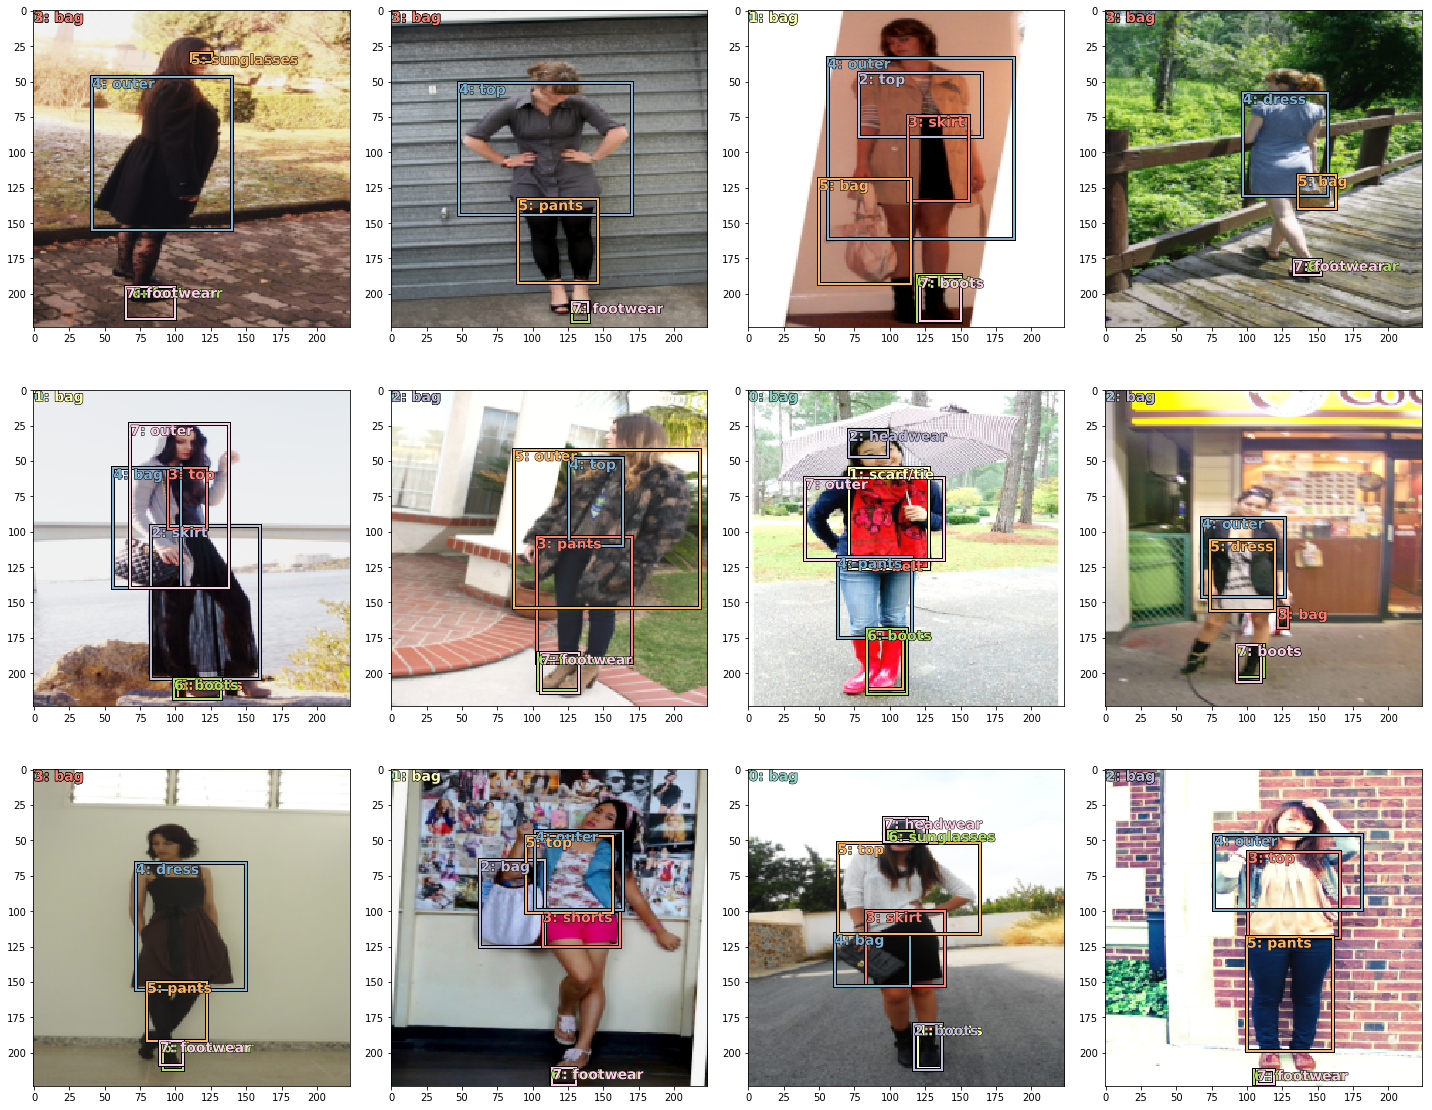

In [19]:
x,y=to_np(next(iter(md.trn_dl)))
x=md.trn_ds.ds.denorm(x)

fig, axes = plt.subplots(3, 4, figsize=(20, 16))
for i,ax in enumerate(axes.flat):
    show_ground_truth(ax, x[i], y[0][i], y[1][i])
plt.tight_layout()

In [20]:
def hw2corners(ctr, hw): return torch.cat([ctr-hw/2, ctr+hw/2], dim=1)

In [21]:
anc_grids = [28,14,7,4,2,1]
anc_zooms =  [.7, 2**0, 2**(1/3), 2**(2/3)]
anc_ratios = [(1.,1.), (.5,1.), (1.,.5), (3.,1.), (1.,3.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = V(np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids]), requires_grad=False).unsqueeze(1)
anchors = V(np.concatenate([anc_ctrs, anc_sizes], axis=1), requires_grad=False).float()
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

In [22]:
def one_hot_embedding(labels, num_classes):
    return torch.eye(num_classes)[labels.data.cpu()]

class BCE_Loss(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
    
    def forward(self, preds, targets):
        t = one_hot_embedding(targets, self.num_classes+1)
        t = V(t[:,:-1].contiguous()) #bg class is predicted when none of the others go out.
        x = preds[:,:-1]
        w = self.get_weight(x,t)# for the last part
        return F.binary_cross_entropy_with_logits(x, t, w, size_average=False) / self.num_classes
    
    def get_weight(self,x,t):
        return None

class FocalLoss(BCE_Loss):
    def get_weight(self,x,t):
        alpha,gamma = 0.25,1.
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = alpha*t + (1-alpha)*(1-t)
        return w * (1-pt).pow(gamma)

loss_f = FocalLoss(len(id2cat))

In [23]:
class StdConv(nn.Module):
    def __init__(self, n_in,n_out,stride=2,dp = 0.1):
        super().__init__()
        self.conv = nn.Conv2d(n_in,n_out,3,stride=stride,padding=1)
        self.bn = nn.BatchNorm2d(n_out)
        self.dropout = nn.Dropout(dp)
        
    def forward(self,x):
        return self.dropout(self.bn(F.relu(self.conv(x))))
    
class OutConv(nn.Module):
    def __init__(self, k, n_in, bias):
        super().__init__()
        self.k = k
        self.oconv1 = nn.Conv2d(n_in, (len(id2cat)+1) * k, 3, padding=1)
        self.oconv2 = nn.Conv2d(n_in, 4 * k, 3, padding = 1)
        self.oconv1.bias.data.zero_().add_(bias)
        
    def forward(self,x):
        return [flatten_conv(self.oconv1(x), self.k),
                flatten_conv(self.oconv2(x), self.k)]
    
def flatten_conv(x,k):
    bs,nf,gx,gy = x.size()
    x = x.permute(0,2,3,1).contiguous()
    return x.view(bs,-1,nf//k)

In [24]:
def intersection(box_a,box_b):
    min_xy = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    max_xy = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp(max_xy-min_xy,min=0)
    return inter[:,:,0] * inter[:,:,1]

def get_size(box):
    return (box[:,2]-box[:,0]) * (box[:,3] - box[:,1])

def jaccard(box_a,box_b):
    inter = intersection(box_a,box_b)
    union = get_size(box_a).unsqueeze(1) + get_size(box_b).unsqueeze(0) - inter
    return inter/union

#Removes the zero padding in the target bbox/class
def get_y(bbox,clas):
    bbox = bbox.view(-1,4)/size
    bb_keep = ((bbox[:,2] - bbox[:,0])>0.).nonzero()[:,0]
    return bbox[bb_keep], clas[bb_keep]
    
def actn_to_bb(actn, anchors):
    actn_bbs = actn
    actn_ctrs = torch.clamp(((actn_bbs[:,:2] * grid_sizes) + anchors[:,:2]),0,size)
    actn_hw = torch.clamp(((1 + actn_bbs[:,2:]) * anchors[:,2:]),0,size)
    return hw2corners(actn_ctrs,actn_hw)

def map_to_ground_truth(overlaps, print_it=False):
    prior_overlap, prior_idx = overlaps.max(1)
    #if print_it: print(prior_overlap)
#     pdb.set_trace()
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

def ssd_1_loss(b_c,b_bb,bbox,clas,print_it=False, use_ab=True):
    bbox,clas = get_y(bbox,clas)
    a_ic = actn_to_bb(b_bb, anchors)
    overlaps = jaccard(bbox.data, (anchor_cnr if use_ab else a_ic).data)
    gt_overlap,gt_idx = map_to_ground_truth(overlaps,print_it)
    gt_clas = clas[gt_idx]
    pos = gt_overlap > 0.4
    pos_idx = torch.nonzero(pos)[:,0]
    gt_clas[1-pos] = len(id2cat)
    gt_bbox = bbox[gt_idx]
    loc_loss = ((a_ic[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    clas_loss  = loss_f(b_c, gt_clas)/len(pos_idx)
    return loc_loss, clas_loss

def ssd_loss(pred,targ,print_it=False):
#     pdb.set_trace()
    lcs,lls = 0.,0.
    for b_c,b_bb,bbox,clas in zip(*pred,*targ):
        if  len(((bbox.view(-1,4)[:,2]-bbox.view(-1,4)[:,0])>0).nonzero())==0:
            continue
        loc_loss,clas_loss = ssd_1_loss(b_c,b_bb,bbox,clas,print_it)
        lls += loc_loss
        lcs += clas_loss
    if print_it: print(f'loc: {lls.data[0]}, clas: {lcs.data[0]}')
    return lls+lcs

In [25]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): 
        self.features = output
        self.features_in = input
    def remove(self): self.hook.remove()

In [26]:
cut,lr_cut = model_meta[f_model]
def get_base():
    layers = cut_model(f_model(True), cut)
    return nn.Sequential(*layers)

In [27]:
drop = 0.4

class SSD_Custom4(nn.Module):
    def __init__(self, m_base, k, bias):
        super().__init__()

        self.m_base = m_base
        self.sfs = [SaveFeatures(m_base[i]) for i in [5,6]] # 28, 14
        
        self.drop = nn.Dropout(drop)
        self.layer2 = StdConv(512,256, dp=drop, stride=1) # 7
        self.layer3 = StdConv(256,256, dp=drop) # 4
        self.layer4 = StdConv(256,256, dp=drop) # 2
        self.layer5 = StdConv(256,256, dp=drop) # 1
        
        self.lat6 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat5 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat4 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat3 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat2 = nn.Conv2d(256,256,kernel_size=1, stride=1, padding=0)
        self.lat1 = nn.Conv2d(128,256,kernel_size=1, stride=1, padding=0)
        
        self.upsamp2 = nn.Upsample(size=(2,2), mode='bilinear')
        self.upsamp4 = nn.Upsample(size=(4,4), mode='bilinear')
        self.upsamp7 = nn.Upsample(size=(7,7), mode='bilinear') # can't use nearest interpol for 4x4 -> 7x7
        self.upsamp14 = nn.Upsample(size=(14,14), mode='bilinear')
        self.upsamp28 = nn.Upsample(size=(28,28), mode='bilinear')
        
        self.out1 = OutConv(k, 256, bias)
        self.out2 = OutConv(k, 256, bias)
        self.out3 = OutConv(k, 256, bias)
        self.out4 = OutConv(k, 256, bias)
        self.out5 = OutConv(k, 256, bias)
        self.out6 = OutConv(k, 256, bias)

    def forward(self,x):
#         pdb.set_trace()
        x = self.drop(F.relu(self.m_base(x)))
        
        c1 = F.relu(self.sfs[0].features) # 28
        c2 = F.relu(self.sfs[1].features) # 14
        c3 = self.layer2(x) # 7
        c4 = self.layer3(c3) # 4
        c5 = self.layer4(c4) # 2
        c6 = self.layer5(c5) # 1
       
        p6 = self.lat6(c6)
        p5 = self.upsamp2(p6) + self.lat5(c5)    
        p4 = self.upsamp4(p5) + self.lat4(c4)
        p3 = self.upsamp7(p4) + self.lat3(c3)
        p2 = self.upsamp14(p3) + self.lat2(c2)
        p1 = self.upsamp28(p2) + self.lat1(c1)
        
        o1c,o1l = self.out1(p1)
        o2c,o2l = self.out2(p2)
        o3c,o3l = self.out3(p3)
        o4c,o4l = self.out4(p4)
        o5c,o5l = self.out5(p5)
        o6c,o6l = self.out6(p6)
        
        return [torch.cat([o1c,o2c,o3c,o4c,o5c,o6c], dim=1),
                torch.cat([o1l,o2l,o3l,o4l,o5l,o6l], dim=1)]

In [28]:
class MakeModel():
    def __init__(self,model,name='makemodel'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.m_base), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [29]:
pi = 0.01
bias = -np.log((1-pi)/pi)

m_base = get_base()
m = to_gpu(SSD_Custom4(m_base,k,bias))
models = MakeModel(m)
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam
learn.crit = ssd_loss

In [30]:
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

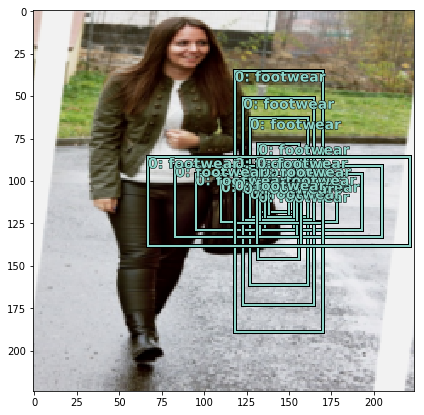

In [45]:
idx=7
ancs = [1005]
x,y=to_np(next(iter(md.trn_dl)))
ima=md.val_ds.ds.denorm(to_np(x))[idx]
fig, ax = plt.subplots(figsize=(7,7))
for i in [a*k for a in ancs]:
    for j in range(k):
        torch_gt(ax, ima, anchor_cnr[i+j], V(3))

In [32]:
lr=4e-4
lrs = np.array([lr/100,lr/10,lr])

In [67]:
learn.lr_find(lr/10,lr*1e4)

 54%|█████▍    | 158/293 [09:13<05:58,  2.66s/it, loss=46.8]

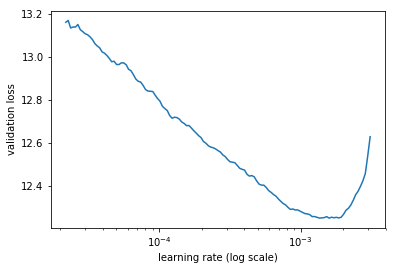

In [70]:
learn.sched.plot(20,10)

In [33]:
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,10))
learn.save("fpn-modanet")

  0%|          | 0/293 [00:00<?, ?it/s]



KeyboardInterrupt



In [35]:
learn.load("fpn-modanet")
learn.freeze_to(-2)
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,10))
learn.save("fpn-modanet2")

epoch      trn_loss   val_loss                              
    0      10.429453  9.812138  
    1      9.795124   9.332919                              
    2      9.470885   9.056976                              
    3      9.236015   8.904377                              
    4      9.166478   8.822157                              



In [36]:
learn.load("fpn-modanet2")
learn.unfreeze()
lr = 1e-3
lrs = np.array([lr/100,lr/10,lr])
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,10))
learn.save("fpn-modanet3")

epoch      trn_loss   val_loss                              
    0      9.275168   8.887424  
    1      8.496732   8.297906                              
    2      8.042755   8.275206                              
    3      7.67282    7.672128                              
    4      7.380314   7.516076                              



In [42]:
learn.load("fpn-modanet3")
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,8))
learn.save("fpn-modanet4")

epoch      trn_loss   val_loss                              
    0      7.926323   7.9748    
    1      7.571237   7.765837                              
    2      7.256618   7.533482                              
    3      7.008097   7.43363                               
    4      6.766474   7.278029                              



In [43]:
learn.load("fpn-modanet4")
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,8))
learn.save("fpn-modanet5")

epoch      trn_loss   val_loss                              
    0      7.274914   7.754375  
    1      7.044124   7.550718                              
    2      6.777155   7.394659                              
    3      6.50103    7.298274                              
    4      6.31659    7.233933                              



In [34]:
learn.load("fpn-modanet5")
learn.unfreeze()
learn.fit(lrs, 1, cycle_len=5, use_clr=(20,8))
learn.save("fpn-modanet6")

epoch      trn_loss   val_loss                              
    0      6.437122   7.381928  
    1      6.352255   7.324566                              
    2      6.228055   7.302572                              
    3      6.127093   7.280617                              
    4      6.023815   7.256684                              



In [35]:
def get1preds(b_clas,b_bb,bbox,clas,thresh=0.25):
    bbox,clas = get_y(bbox, clas)
    a_ic = actn_to_bb(b_bb, anchors)
    clas_pr, clas_ids = b_clas.max(1)
    conf_scores = b_clas.sigmoid().t().data
    out1,out2,cc = [],[],[]
    for cl in range(conf_scores.size(0)-1):
        cl_mask = conf_scores[cl] > thresh
        if cl_mask.sum() == 0: continue
        scores = conf_scores[cl][cl_mask]
        l_mask = cl_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    cc = T(np.concatenate(cc)) if cc != [] else None
    out1 = torch.cat(out1) if out1 != [] else None
    out2 = torch.cat(out2) if out2 != [] else None
    return out1,out2,cc

def count(L):
    result = collections.defaultdict(int)
    if L is not None:
        for x in L:
            result[x] += 1
    return result

from ipywidgets import FloatProgress
from IPython.display import display
def multiTPFPFN():
    n = 40
    threshes = np.linspace(.05, 0.95, n, endpoint=True)
    tps,fps,fns = np.zeros((n,len(id2cat))),np.zeros((n,len(id2cat))),np.zeros((n,len(id2cat)))
    prog = FloatProgress(min=0,max=len(md.val_dl))
    display(prog)
    for data in md.val_dl:
        x,y = data
        x,y = V(x),V(y)
        pred = learn.model(x)
        for idx in range(x.size(0)):
            bbox,clas = get_y(y[0][idx],y[1][idx])#unpad the target
            p_scrs,p_box,p_cls = get1preds(pred[0][idx],pred[1][idx],y[0][idx],y[1][idx],threshes[0])
            overlaps = to_np(jaccard(p_box,bbox.data))
            overlaps = np.where(overlaps > 0.5, overlaps, 0)
            clas, np_scrs, np_cls = to_np(clas.data),to_np(p_scrs), to_np(p_cls)
            for k in range(threshes.shape[0]):
                new_tp = collections.defaultdict(int)
                for cls in list(set(clas)):
                    msk_clas = np.bitwise_and((clas == cls)[None,:],(np_cls == cls)[:,None])
                    ov_clas = np.where(msk_clas,overlaps,0.)
                    mx_idx = np.argmax(ov_clas,axis=1)
                    for i in range(0,len(clas)):
                        if (clas[i] == cls):
                            keep = np.bitwise_and(np.max(ov_clas,axis=1) > 0.,mx_idx==i)
                            keep = np.bitwise_and(keep,np_scrs > threshes[k])
                            if keep.sum() > 0:
                                new_tp[cls] += 1
                count_pred = count(np_cls[np_scrs > threshes[k]])
                count_gt = count(clas)
                for c in range(len(id2cat)):
                    tps[k,c] += new_tp[c]
                    fps[k,c] += count_pred[c] - new_tp[c]
                    fns[k,c] += count_gt[c] - new_tp[c]
        prog.value += 1 
    return tps, fps, fns

tps, fps, fns = multiTPFPFN()

def avg_prec(clas):
    eps = 1e-15
    precisions = tps[:,clas]/(tps[:,clas] + fps[:,clas] + eps)
    recalls = tps[:,clas]/(tps[:,clas] + fns[:,clas] + eps)
    prec_at_rec = []
    for recall_level in np.linspace(0.0, 1.0, 11):
        try:
            args = np.argwhere(recalls >= recall_level).flatten()
            prec = max(precisions[args])
        except ValueError:
            prec = 0.0
        prec_at_rec.append(prec)
    return np.array(prec_at_rec).mean()

def mAP():
    S = 0
    for i in range(len(id2cat)):
        S += avg_prec(i)
    return S/len(id2cat)

FloatProgress(value=0.0, max=74.0)

/home/vanio/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in greater


In [36]:
mAP()

0.5647696772109645

In [39]:
def plot_results(thresh):
    x,y = next(iter(md.val_dl))
    y = V(y)
    batch = learn.model(V(x))
    b_clas,b_bb = batch

    x = to_np(x)
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    for idx,ax in enumerate(axes.flat):
        ima=md.val_ds.ds.denorm(x)[idx]
        bbox,clas = get_y(y[0][idx], y[1][idx])
        a_ic = actn_to_bb(b_bb[idx], anchors)
        clas_pr, clas_ids = b_clas[idx].max(1)
        clas_pr = clas_pr.sigmoid()
        torch_gt(ax, ima, a_ic, clas_ids, clas_pr, clas_pr.max().data[0]*thresh)
    plt.tight_layout()

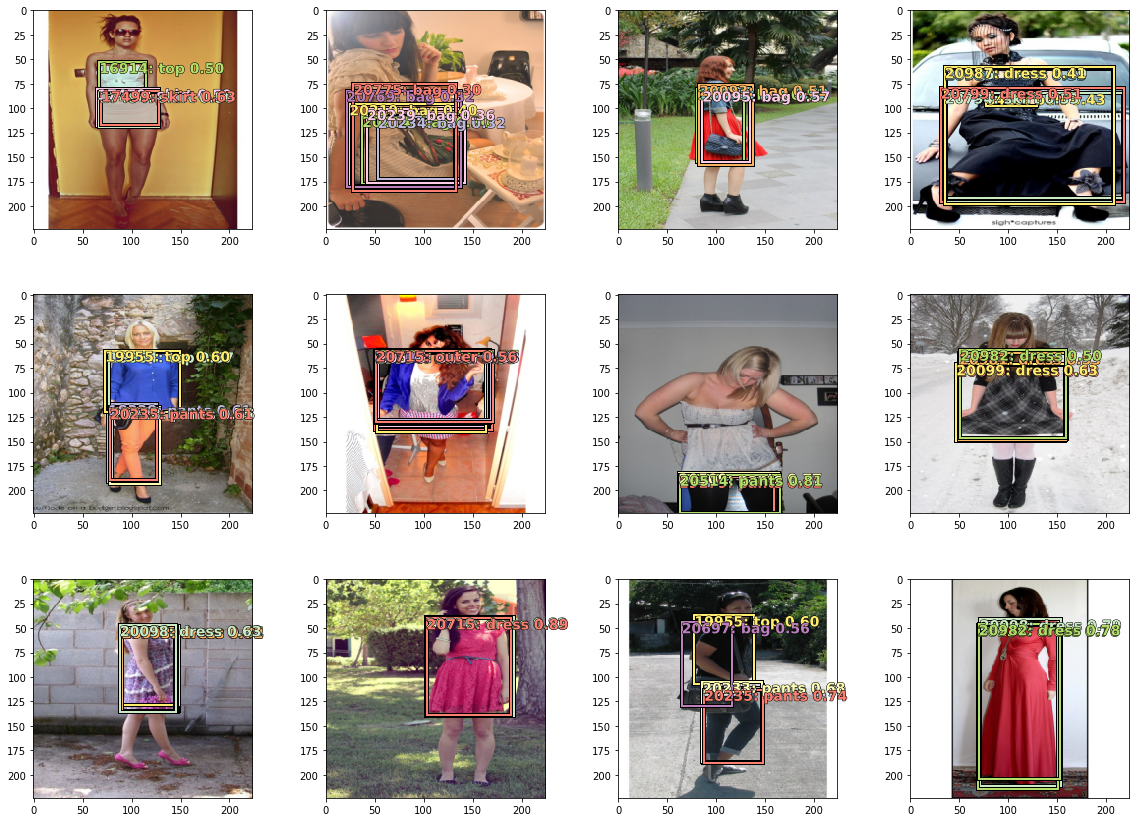

In [41]:
plot_results(0.75)

In [31]:
def getSinglePred(fn):
    image = open_image(fn)
    image = tfms[1](image,np.array([1,2,3,4]))
    ima=md.val_ds.ds.denorm(image[0][None])

    learn.model.cuda()
    learn.model.eval()
    pred_class,pred_bb = learn.model(V(image[0][None]))
    a_ic = actn_to_bb(pred_bb[0], anchors)
    clas_pr, clas_ids = pred_class[0].max(1)
    clas_pr = clas_pr.sigmoid()
    
    conf_scores = pred_class[0].sigmoid().t().data
    
    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        pdb.set_trace
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)

    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)
    
    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima[0], out2, cc, out1, 0.1)

getSinglePred("image_data/e840fedbcd2f9993452cc8fa0f366b6d.jpg")


11: empty array


In [65]:
def show_nmf(idx):
    ima=md.val_ds.ds.denorm(x)[idx]
    bbox,clas = get_y(y[0][idx], y[1][idx])
    a_ic = actn_to_bb(b_bb[idx], anchors)
    clas_pr, clas_ids = b_clas[idx].max(1)
    clas_pr = clas_pr.sigmoid()

    conf_scores = b_clas[idx].sigmoid().t().data

    out1,out2,cc = [],[],[]
    for cl in range(0, len(conf_scores)-1):
        c_mask = conf_scores[cl] > 0.25
        if c_mask.sum() == 0: continue
        scores = conf_scores[cl][c_mask]
        l_mask = c_mask.unsqueeze(1).expand_as(a_ic)
        boxes = a_ic[l_mask].view(-1, 4)
        ids, count = nms(boxes.data, scores, 0.4, 50)
        ids = ids[:count]
        out1.append(scores[ids])
        out2.append(boxes.data[ids])
        cc.append([cl]*count)
    if not cc:
        print(f"{i}: empty array")
        return
    cc = T(np.concatenate(cc))
    out1 = torch.cat(out1)
    out2 = torch.cat(out2)

    fig, ax = plt.subplots(figsize=(8,8))
    torch_gt(ax, ima, out2, cc, out1, 0.1)

x,y = next(iter(md.val_dl))
y = V(y)
batch = learn.model(V(x))
b_clas,b_bb = batch
for i in range(12): show_nmf(i)
